<a href="https://colab.research.google.com/github/changsin/DL/blob/main/CNN_Week2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 2: Deep Convolutional Models



In [3]:
import tensorflow as tf
import numpy as np
import scipy.misc
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
# from resnets_utils import *
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.python.framework.ops import EagerTensor
from matplotlib.pyplot import imshow

# from test_utils import summary, comparator
# import public_tests

%matplotlib inline

## 3.1 - identity_block

The identity block is the standard block used in ResNets, and corresponds to the case where the input activation (say $a^{[l]}$) has the same dimension as the output activation (say $a^{[l+2]}$). To flesh out the different steps of what happens in a ResNet's identity block, here is an alternative diagram showing the individual steps:

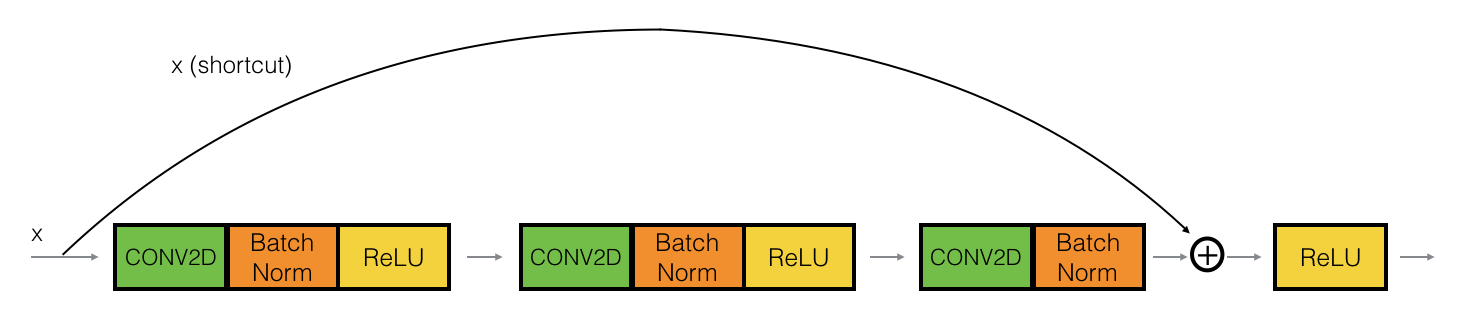

In [4]:
# UNQ_C1
# GRADED FUNCTION: identity_block

def identity_block(X, f, filters, training=True, initializer=random_uniform):
    """
    Implementation of the identity block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to random uniform initializer
    
    Returns:
    X -- output of the identity block, tensor of shape (m, n_H, n_W, n_C)
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    """
    First component of main path:
    The first CONV2D has  𝐹1  filters of shape (1,1) and a stride of (1,1). Its padding is "valid". Use 0 as the seed for the random uniform initialization: kernel_initializer = initializer(seed=0).
    The first BatchNorm is normalizing the 'channels' axis.
    Then apply the ReLU activation function. This has no hyperparameters.
    """
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training) # Default axis
    X = Activation('relu')(X)
    
    ### START CODE HERE
    """
    Second component of main path:
    The second CONV2D has  𝐹2  filters of shape  (𝑓,𝑓)  and a stride of (1,1). Its padding is "same". Use 0 as the seed for the random uniform initialization: kernel_initializer = initializer(seed=0).
    The second BatchNorm is normalizing the 'channels' axis.
    Then apply the ReLU activation function. This has no hyperparameters.
    """
    ## Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = f, strides = (1,1), padding = 'same', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training) # Default axis
    X = Activation('relu')(X)

    """
    Third component of main path:
    The third CONV2D has  𝐹3  filters of shape (1,1) and a stride of (1,1). Its padding is "valid". Use 0 as the seed for the random uniform initialization: kernel_initializer = initializer(seed=0).
    The third BatchNorm is normalizing the 'channels' axis.
    Note that there is no ReLU activation function in this component.
    """
    
    ## Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training) # Default axis

    """
    Final step:
    The X_shortcut and the output from the 3rd layer X are added together.
    Hint: The syntax will look something like Add()([var1,var2])
    Then apply the ReLU activation function. This has no hyperparameters
    """
    ## Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    ### END CODE HERE

    return X

In [5]:
np.random.seed(1)
X1 = np.ones((1, 4, 4, 3)) * -1
X2 = np.ones((1, 4, 4, 3)) * 1
X3 = np.ones((1, 4, 4, 3)) * 3

X = np.concatenate((X1, X2, X3), axis = 0).astype(np.float32)

A3 = identity_block(X, f=2, filters=[4, 4, 3],
                   initializer=lambda seed=0:constant(value=1),
                   training=False)
print('\033[1mWith training=False\033[0m\n')
A3np = A3.numpy()
print(np.around(A3.numpy()[:,(0,-1),:,:].mean(axis = 3), 5))
resume = A3np[:,(0,-1),:,:].mean(axis = 3)
print(resume[1, 1, 0])

print('\n\033[1mWith training=True\033[0m\n')
np.random.seed(1)
A4 = identity_block(X, f=2, filters=[3, 3, 3],
                   initializer=lambda seed=0:constant(value=1),
                   training=True)
print(np.around(A4.numpy()[:,(0,-1),:,:].mean(axis = 3), 5))

# public_tests.identity_block_test(identity_block)

With training=False

[[[  0.        0.        0.        0.     ]
  [  0.        0.        0.        0.     ]]

 [[192.71234 192.71234 192.71234  96.85617]
  [ 96.85617  96.85617  96.85617  48.92808]]

 [[578.1371  578.1371  578.1371  290.5685 ]
  [290.5685  290.5685  290.5685  146.78426]]]
96.85617

With training=True

[[[0.      0.      0.      0.     ]
  [0.      0.      0.      0.     ]]

 [[0.40739 0.40739 0.40739 0.40739]
  [0.40739 0.40739 0.40739 0.40739]]

 [[4.99991 4.99991 4.99991 3.25948]
  [3.25948 3.25948 3.25948 2.40739]]]


## 3.2 - The Convolutional Block
The ResNet "convolutional block" is the second block type. You can use this type of block when the input and output dimensions don't match up. The difference with the identity block is that there is a CONV2D layer in the shortcut path:



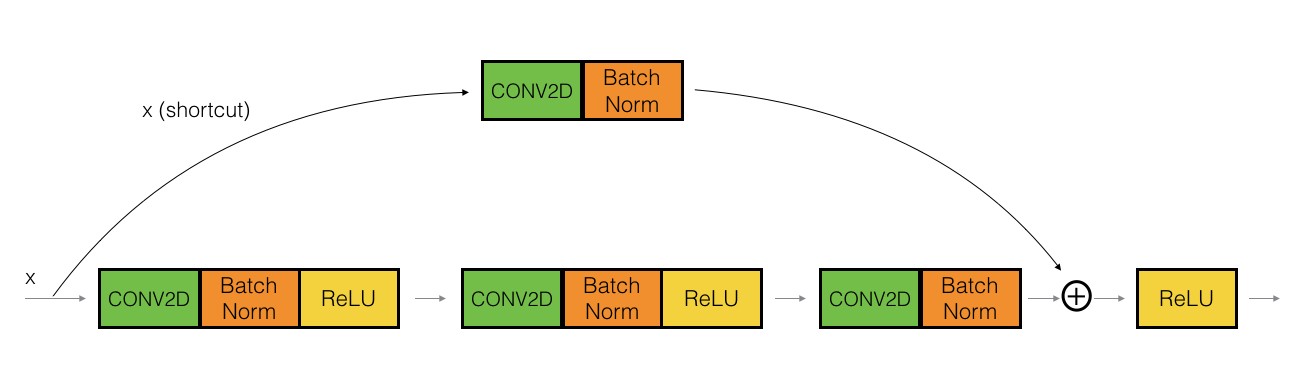

In [6]:
# UNQ_C2
# GRADED FUNCTION: convolutional_block

def convolutional_block(X, f, filters, s = 2, training=True, initializer=glorot_uniform):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    s -- Integer, specifying the stride to be used
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to Glorot uniform initializer, 
                   also called Xavier uniform initializer.
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    
    # First component of main path glorot_uniform(seed=0)
    X = Conv2D(filters = F1, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)

    ### START CODE HERE
    
    ## Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = f, strides = (1,1), padding = 'same', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training) # Default axis
    X = Activation('relu')(X)

    """
    Third component of main path:
    The third CONV2D has  𝐹3  filters of shape (1,1) and a stride of (1,1).
    Its padding is "valid". Use 0 as the seed for the random uniform initialization:
    kernel_initializer = initializer(seed=0).
    The third BatchNorm is normalizing the 'channels' axis.
    Note that there is no ReLU activation function in this component.
    """
    
    ## Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training) # Default axis

    ##### SHORTCUT PATH ##### (≈2 lines)
    """
    The CONV2D layer in the shortcut path is used to resize the input  𝑥  to a different dimension,
    so that the dimensions match up in the final addition needed to add the shortcut value back to the main path.
    (This plays a similar role as the matrix  𝑊𝑠  discussed in lecture.)
    For example, to reduce the activation dimensions's height and width by a factor of 2,
    you can use a 1x1 convolution with a stride of 2.

    The CONV2D layer on the shortcut path does not use any non-linear activation function.
    Its main role is to just apply a (learned) linear function that reduces the dimension of the input,
    so that the dimensions match up for the later addition step.
    As for the previous exercise, the additional initializer argument is required for grading purposes,
    and it has been set by default to glorot_uniform

    The CONV2D has  𝐹3  filters of shape (1,1) and a stride of (s,s). Its padding is "valid". Use 0 as the glorot_uniform seed kernel_initializer = initializer(seed=0).
    The BatchNorm is normalizing the 'channels' axis.
    """
    X_shortcut = Conv2D(filters = F3, kernel_size = 1, strides = (s,s), padding = 'valid', kernel_initializer = initializer(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3)(X_shortcut, training = training) # Default axis

    ### END CODE HERE

    # Final step: Add shortcut value to main path (Use this order [X, X_shortcut]), and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [7]:
# from outputs import convolutional_block_output1, convolutional_block_output2
np.random.seed(1)
#X = np.random.randn(3, 4, 4, 6).astype(np.float32)
X1 = np.ones((1, 4, 4, 3)) * -1
X2 = np.ones((1, 4, 4, 3)) * 1
X3 = np.ones((1, 4, 4, 3)) * 3

X = np.concatenate((X1, X2, X3), axis = 0).astype(np.float32)

A = convolutional_block(X, f = 2, filters = [2, 4, 6], training=False)

assert type(A) == EagerTensor, "Use only tensorflow and keras functions"
assert tuple(tf.shape(A).numpy()) == (3, 2, 2, 6), "Wrong shape."
# assert np.allclose(A.numpy(), convolutional_block_output1), "Wrong values when training=False."
print(A[0])

B = convolutional_block(X, f = 2, filters = [2, 4, 6], training=True)
# assert np.allclose(B.numpy(), convolutional_block_output2), "Wrong values when training=True."

print('\033[92mAll tests passed!')


tf.Tensor(
[[[1.6174057  0.         0.42508614 0.         0.6224667  0.04615025]
  [1.5492405  0.         0.2778667  0.         0.39416897 0.        ]]

 [[1.6215825  0.         0.4341072  0.         0.636456   0.05398376]
  [1.5335128  0.         0.2438989  0.         0.34149405 0.        ]]], shape=(2, 2, 6), dtype=float32)
All tests passed!


## 4: ResNet50

The details of this ResNet-50 model are:
- Zero-padding pads the input with a pad of (3,3)
- Stage 1:
    - The 2D Convolution has 64 filters of shape (7,7) and uses a stride of (2,2). 
    - BatchNorm is applied to the 'channels' axis of the input.
    - ReLU activation is applied.
    - MaxPooling uses a (3,3) window and a (2,2) stride.
- Stage 2:
    - The convolutional block uses three sets of filters of size [64,64,256], "f" is 3, and "s" is 1.
    - The 2 identity blocks use three sets of filters of size [64,64,256], and "f" is 3.
- Stage 3:
    - The convolutional block uses three sets of filters of size [128,128,512], "f" is 3 and "s" is 2.
    - The 3 identity blocks use three sets of filters of size [128,128,512] and "f" is 3.
- Stage 4:
    - The convolutional block uses three sets of filters of size [256, 256, 1024], "f" is 3 and "s" is 2.
    - The 5 identity blocks use three sets of filters of size [256, 256, 1024] and "f" is 3.
- Stage 5:
    - The convolutional block uses three sets of filters of size [512, 512, 2048], "f" is 3 and "s" is 2.
    - The 2 identity blocks use three sets of filters of size [512, 512, 2048] and "f" is 3.
- The 2D Average Pooling uses a window of shape (2,2).
- The 'flatten' layer doesn't have any hyperparameters.
- The Fully Connected (Dense) layer reduces its input to the number of classes using a softmax activation.


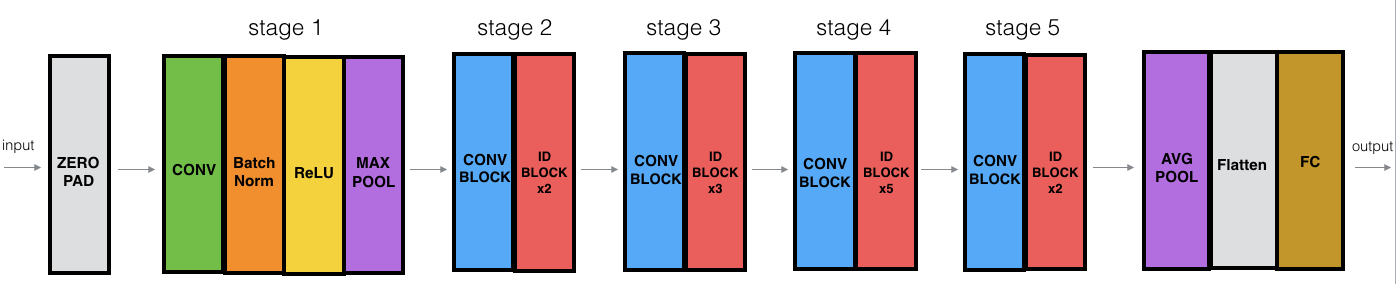

In [8]:
# UNQ_C3
# GRADED FUNCTION: ResNet50

def ResNet50(input_shape = (64, 64, 3), classes = 6):
    """
    Stage-wise implementation of the architecture of the popular ResNet50:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> FLATTEN -> DENSE 

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)

    """
    Stage 1:
    The 2D Convolution has 64 filters of shape (7,7) and uses a stride of (2,2).
    BatchNorm is applied to the 'channels' axis of the input.
    ReLU activation is applied.
    MaxPooling uses a (3,3) window and a (2,2) stride.
    """
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    """
    Stage 2:
    The convolutional block uses three sets of filters of size [64,64,256], "f" is 3, and "s" is 1.
    The 2 identity blocks use three sets of filters of size [64,64,256], and "f" is 3.
    """
    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])

    ### START CODE HERE
    """
    Stage 3:
    The convolutional block uses three sets of filters of size [128,128,512], "f" is 3 and "s" is 2.
    The 3 identity blocks use three sets of filters of size [128,128,512] and "f" is 3.
    """  
    ## Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], s = 2)
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])
   
    """
    Stage 4:
    The convolutional block uses three sets of filters of size [256, 256, 1024], "f" is 3 and "s" is 2.
    The 5 identity blocks use three sets of filters of size [256, 256, 1024] and "f" is 3.
    """
    ## Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], s = 2)
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])

    """
    Stage 5:
    The convolutional block uses three sets of filters of size [512, 512, 2048], "f" is 3 and "s" is 2.
    The 2 identity blocks use three sets of filters of size [512, 512, 2048] and "f" is 3.
    """
    ## Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], s = 2)
    X = identity_block(X, 3, [512, 512, 2048])
    X = identity_block(X, 3, [512, 512, 2048])

    """
    The 2D Average Pooling uses a window of shape (2,2).
    The 'flatten' layer doesn't have any hyperparameters.
    The Fully Connected (Dense) layer reduces its input to the number of classes using a softmax activation.

    """
    ## AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D(pool_size=(2, 2), strides=None, padding='valid')(X)
    
    ### END CODE HERE

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X)

    return model

In [10]:
# from outputs import ResNet50_summary

model = ResNet50(input_shape = (64, 64, 3), classes = 6)

# comparator(summary(model), ResNet50_summary)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Transfer Learning with MobileNetV2

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation


In [14]:
# UNQ_C1
# GRADED FUNCTION: data_augmenter
def data_augmenter():
    '''
    Create a Sequential model composed of 2 layers
    Returns:
        tf.keras.Sequential
    '''
    ### START CODE HERE
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip('horizontal'))
    data_augmentation.add(RandomRotation(0.2))
    ### END CODE HERE
    
    return data_augmentation

In [15]:
augmenter = data_augmenter()

assert(augmenter.layers[0].name.startswith('random_flip')), "First layer must be RandomFlip"
assert augmenter.layers[0].mode == 'horizontal', "RadomFlip parameter must be horizontal"
assert(augmenter.layers[1].name.startswith('random_rotation')), "Second layer must be RandomRotation"
assert augmenter.layers[1].factor == 0.2, "Rotation factor must be 0.2"
assert len(augmenter.layers) == 2, "The model must have only 2 layers"

print('\033[92mAll tests passed!')


All tests passed!


In [18]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [17]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')

14548992/14536120 [==============================] - 0s 0us/step


In [19]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_2[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [20]:
nb_layers = len(base_model.layers)
print(base_model.layers[nb_layers - 2].name)
print(base_model.layers[nb_layers - 1].name)

global_average_pooling2d
predictions


## 4.2 Layer Freezing with the Functional API

In [21]:
# UNQ_C2
# GRADED FUNCTION
def alpaca_model(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
    ''' Define a tf.keras model for binary classification out of the MobileNetV2 model
    Arguments:
        image_shape -- Image width and height
        data_augmentation -- data augmentation function
    Returns:
    Returns:
        tf.keras.model
    '''
    
    
    input_shape = image_shape + (3,)
    
    ### START CODE HERE
    
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False, # <== Important!!!!
                                                   weights='imagenet') # From imageNet
    
    # freeze the base model by making it non trainable
    base_model.trainable = False 

    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=input_shape) 
    
    # apply data augmentation to the inputs
    x = data_augmentation(inputs)
    
    # data preprocessing using the same weights the model was trained on
    x = preprocess_input(x) 
    
    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False) 
    
    # add the new Binary classification layers
    # use global avg pooling to summarize the info in each channel
    x = tfl.GlobalAveragePooling2D()(x) 
    # include dropout with probability of 0.2 to avoid overfitting
    x = tfl.Dropout(0.2)(x)
        
    # use a prediction layer with one neuron (as a binary classifier only needs one)
    outputs = tfl.Dense(1, activation = 'linear')(x)
    
    ### END CODE HERE
    
    model = tf.keras.Model(inputs, outputs)
    
    return model

In [23]:
data_augmentation = data_augmenter()
model2 = alpaca_model(IMG_SIZE, data_augmentation)

9420800/9406464 [==============================] - 0s 0us/step


In [25]:
base_learning_rate = 0.001
model2.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


## 4.3 Fine-tune the model

In [27]:
# UNQ_C3
base_model = model2.layers[4]
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 120

### START CODE HERE

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
    
# Define a BinaryCrossentropy loss function. Use from_logits=True
# loss_function=tf.python.keras.losses.BinaryCrossentropy(from_logits=True)

loss_function=tf.keras.losses.BinaryCrossentropy(from_logits=True)
# Define an Adam optimizer with a learning rate of 0.1 * base_learning_rate
optimizer = tf.keras.optimizers.Adam(lr=0.1*base_learning_rate)
# Use accuracy as evaluation metric
metrics=['accuracy']

### END CODE HERE

model2.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)

Number of layers in the base model:  154


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
